<a href="https://colab.research.google.com/github/ikbenali/ReproducibilityProject_DL/blob/main/Reproducibility_project_PINN's_NTK_perspective.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CS4240: Reproducibility project

**Paper**: PINNs through a NTK perspective

Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

1D Poisson PDE functions

In [2]:
# Forcing function
def f(x):
    return -16 * np.pi ** 2 * torch.sin(4 * np.pi * x)

# Boundary condition
def g(x):
    return torch.zeros_like(x)

PINN Class

In [3]:
class PINN(nn.Module):

      def __init__(self, input_size, neurons, output_size):
        super(PINN, self).__init__()
        
        # Define layers
        self.layer1 = nn.Linear(input_size, neurons)
        self.sigmoid = nn.Sigmoid()
        self.layer2 = nn.Linear(neurons, output_size)

      def forward(self, x):
        
        # Calculate output of each layer for input x
        x.requires_grad_(True)
        u1 = self.layer1(x)
        a = self.sigmoid(u1)
        uhat = self.layer2(a)
        
        # Calculate second derivative of uhat: 'uhat_xx'
        uhat_x = torch.autograd.grad(uhat, x, grad_outputs=torch.ones_like(uhat), create_graph=True)[0]
        uhat_xx = torch.autograd.grad(uhat_x, x, grad_outputs=torch.ones_like(uhat_x), create_graph=True)[0]

        return uhat, uhat_xx
              
      def numel(self):
        return sum([p.numel() for p in self.parameters()])

      def get_ntk(self, x):
        uhat, uhat_xx = self.forward(x)
          
        # Calculate Jacobian of uhat wrt to the parameters for NTK
        output_size = uhat.size()[1]
        jacobian_uhat = torch.zeros(output_size, self.numel())
        for i in range(output_size):
            grad_output = torch.zeros_like(uhat)
            grad_output[:, i] = 1.0
            self.zero_grad()
            uhat.backward(grad_output, retain_graph=True)
            jacobian_uhat[i] = torch.cat([param.grad.reshape(-1) for param in self.parameters()])
        ntk_uhat = jacobian_uhat @ jacobian_uhat.T

        # Calculate Jacobian of uhat_xx wrt to the parameters for NTK
        output_size = uhat_xx.size()[1]
        jacobian_uhat_xx = torch.zeros(output_size, self.numel())
        for i in range(output_size):
            grad_output = torch.zeros_like(uhat_xx)
            grad_output[:, i] = 1.0
            self.zero_grad()
            uhat_xx.backward(grad_output, retain_graph=True)
            jacobian_uhat_xx[i] = torch.cat([param.grad.reshape(-1) for param in self.parameters()])
        ntk_uhat_xx = jacobian_uhat_xx @ jacobian_uhat_xx.T

        return ntk_uhat.detach(), ntk_uhat_xx.detach()

Model

In [4]:
# Initialize model
model = PINN(input_size=1, neurons=500, output_size=1)

Loss function

In [5]:
def loss_fn(uhat, uhat_xx, x):

    # Separate xr and xb
    xr = x[:,0]
    xb = x[:,1]

    uhat_r = uhat[:,0];   uhat_r_xx = uhat_xx[:,0]
    uhat_b = uhat[:,1];   uhat_b_xx = uhat_xx[:,1]  
    
    # Calculate residual loss term
    f_xr = f(xr)
    residual_loss = torch.mean((uhat_r_xx - f_xr)**2)

    # Calculate residual boundary loss term
    g_xb = g(xb)
    boundary_loss = torch.mean((uhat_b - g(xb))**2)

    # Calculate total loss
    loss = residual_loss + boundary_loss

    return loss

Optimization

In [6]:
# Stochastic gradient descent
# optim = torch.optim.SGD(model.parameters(), lr=1e-5)

# Adam
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

Training loop

Epoch [1000/10000], Loss: 10283.8174


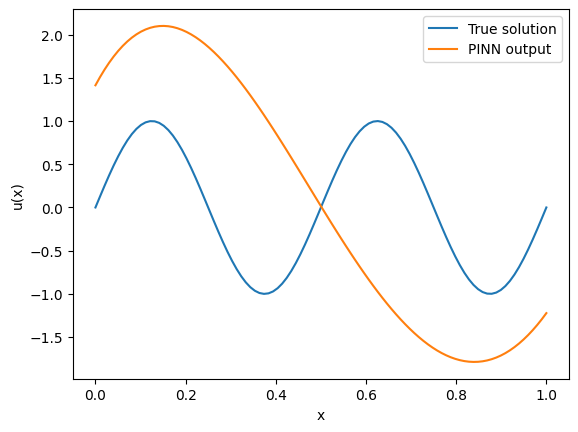

Epoch [2000/10000], Loss: 8348.4229


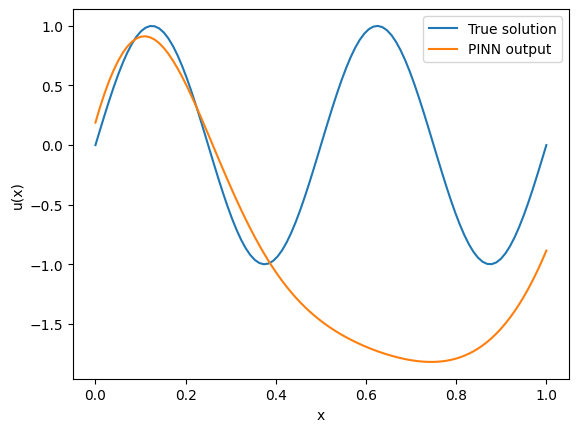

Epoch [3000/10000], Loss: 290.1290


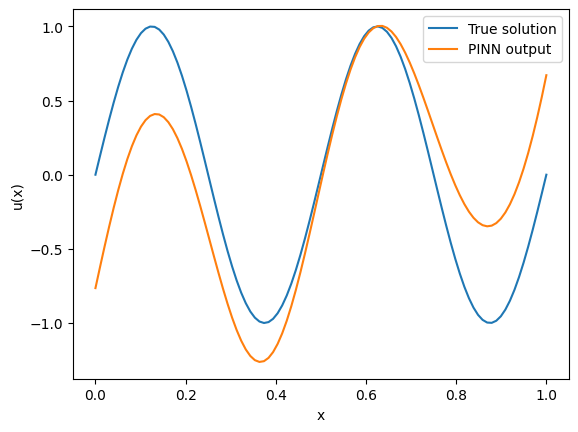

Epoch [4000/10000], Loss: 9.9428


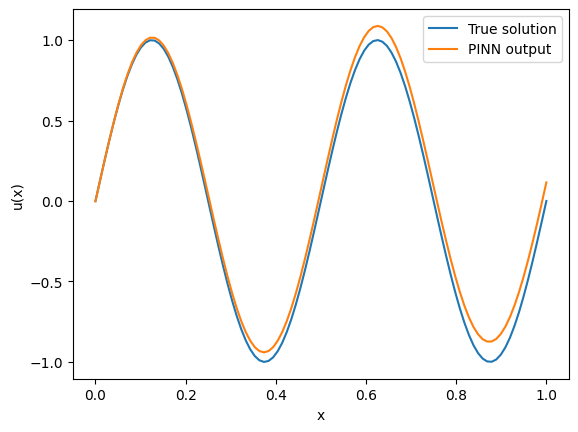

Epoch [5000/10000], Loss: 1.0200


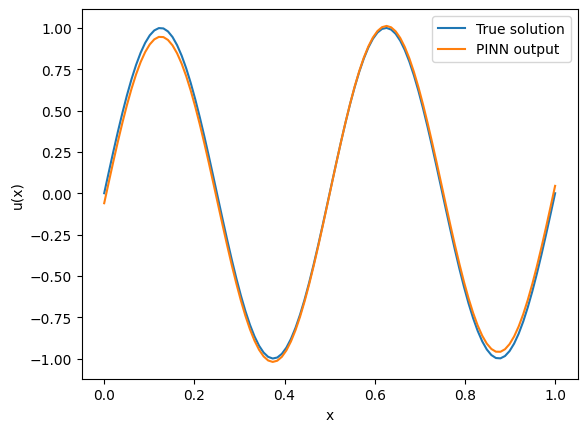

Epoch [6000/10000], Loss: 0.2514


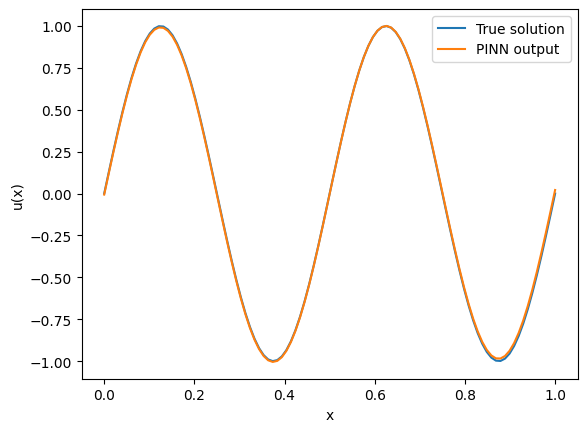

Epoch [7000/10000], Loss: 0.1125


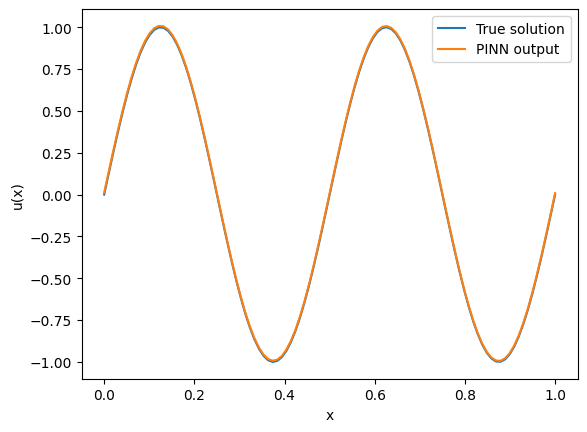

Epoch [8000/10000], Loss: 0.0477


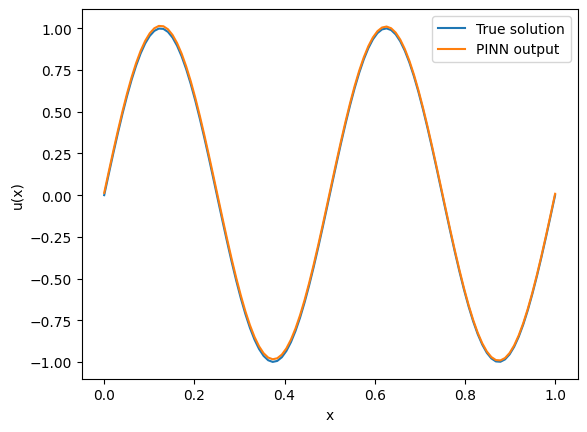

Epoch [9000/10000], Loss: 0.0338


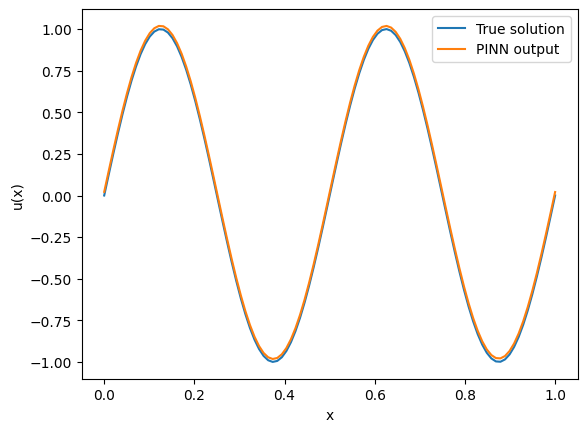

Epoch [10000/10000], Loss: 0.0199


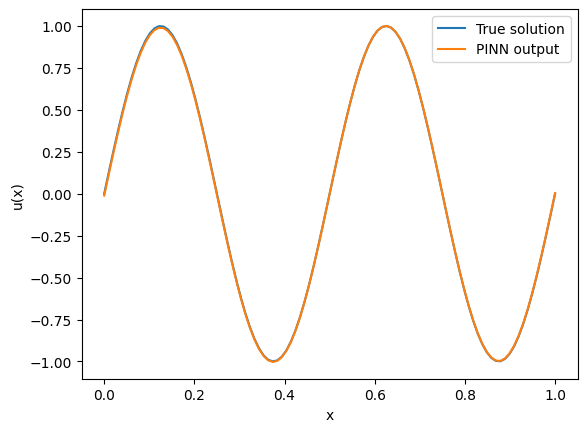

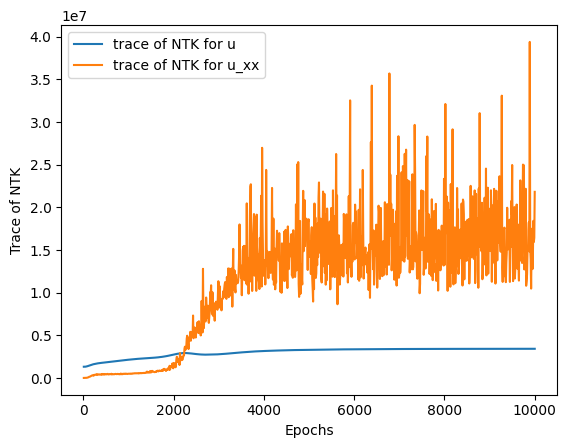

In [7]:
num_epochs = 10000
NTKinterval = 10
trace_uhat = []
trace_uhat_xx = []


repeat = 5
for epoch in range(num_epochs):

    for i in range(repeat):
      
      # Generate 100 random samples within interval [0 1]
      nr = 100
      xr = torch.rand(nr, 1)

      # Generate 100 samples consisting of only 1's and 0's alternating randomly
      nb = 100
      xb = torch.cat((torch.zeros(nb//2, 1), torch.ones(nb//2, 1)), dim=0)
      perm = torch.randperm(nb)
      xb = xb[perm]

      # Predict u(x) using PINN
      uhatr, uhatr_xx = model(xr)
      uhatb, uhatb_xx = model(xb)

      # Concatenate x1 output with x2
      uhatbatch = torch.hstack((uhatr, uhatb))
      uhatbatch_xx = torch.hstack((uhatr_xx, uhatb_xx))
      xbatch = torch.hstack((xr, xb))   

      # Calculate loss 
      loss = loss_fn(uhatbatch, uhatbatch_xx, xbatch)

      # Optimization
      optim.zero_grad()
      loss.backward()
      optim.step()
      # end loop

    # Get NTK submatrices
    if ((epoch+1) % NTKinterval == 0):
      ntk_uhatr, ntk_uhatr_xx = model.get_ntk(xr)
      ntk_uhatb, ntk_uhatb_xx = model.get_ntk(xb) 
      trace_uhat.append(torch.trace(ntk_uhatb).item())
      trace_uhat_xx.append(torch.trace(ntk_uhatr_xx).item())  

    # Show loss after every 1000 epochs
    if (epoch+1) % 1000 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss))

        # Plot true solution vs PINN output
        x_test = torch.linspace(0, 1, 100).reshape(-1, 1)
        u_true = torch.sin(4 * np.pi * x_test)
        uhat = model(x_test)[0]

        plt.plot(x_test.detach().numpy(), u_true.detach().numpy(), label='True solution')
        plt.plot(x_test.detach().numpy(), uhat.detach().numpy(), label='PINN output')
        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.legend()
        plt.show()

# Plot trace of NTK
plt.figure()
plt.plot(range(NTKinterval, num_epochs+1, NTKinterval), trace_uhat, label='trace of NTK for u')
plt.plot(range(NTKinterval, num_epochs+1, NTKinterval), trace_uhat_xx, label='trace of NTK for u_xx')
plt.xlabel('Epochs')
plt.ylabel('Trace of NTK')
plt.legend()
plt.show()